Packages

In [1]:
!git clone https://github.com/cangozpi/Generative-Adversarial-User-Model-for-RL-Based-Recommendation-System.git

Cloning into 'Generative-Adversarial-User-Model-for-RL-Based-Recommendation-System'...
remote: Enumerating objects: 263, done.
remote: Counting objects: 100% (87/87), done.
remote: Compressing objects: 100% (59/59), done.
remote: Total 263 (delta 54), reused 55 (delta 27), pack-reused 176
Receiving objects: 100% (263/263), 400.38 KiB | 4.82 MiB/s, done.
Resolving deltas: 100% (151/151), done.


In [4]:
%cd Generative-Adversarial-User-Model-for-RL-Based-Recommendation-System/

/content/Generative-Adversarial-User-Model-for-RL-Based-Recommendation-System


Processing Datasets

In [5]:
%cd dropbox

/content/Generative-Adversarial-User-Model-for-RL-Based-Recommendation-System/dropbox


In [6]:
import numpy as np
import pickle
import pandas as pd
import argparse

#======================================================================================================
### Explanation of the original .txt file: The column 'session_new_index' corresponds to user ID. 
# The column 'item_new_index' corresponds to item ID. If several items have the same 'Time' index, 
# then they are displayed at the same time (in the same display set).
#======================================================================================================
datasets = ["yelp","tb","rsc"]

for data_set_name in datasets:



  # The format of processed data:
  # data_behavior[user][0] is user_id
  # data_behavior[user][1][t] is displayed list at time t
  # data_behavior[user][2][t] is picked id at time t

  filename = './'+data_set_name+'.txt'

  raw_data = pd.read_csv(filename, sep='\t', usecols=[1, 3, 5, 7, 6], dtype={1: int, 3: int, 7: int, 5:int, 6:int})

  raw_data.drop_duplicates(subset=['session_new_index','Time','item_new_index','is_click'], inplace=True)
  raw_data.sort_values(by='is_click',inplace=True)
  raw_data.drop_duplicates(keep='last', subset=['session_new_index','Time','item_new_index'], inplace=True)

  sizes = raw_data.nunique()
  size_user = sizes['session_new_index']
  size_item = sizes['item_new_index']

  data_user = raw_data.groupby(by='session_new_index')
  data_behavior = [[] for _ in range(size_user)]

  train_user = []
  vali_user = []
  test_user = []

  sum_length = 0
  event_cnt = 0

  for user in range(size_user):
    data_behavior[user] = [[], [], []]
    data_behavior[user][0] = user
    data_u = data_user.get_group(user)
    split_tag = list(data_u['tr_val_tst'])[0]
    if split_tag == 0:
      train_user.append(user)
    elif split_tag == 1:
      vali_user.append(user)
    else:
      test_user.append(user)

    data_u_time = data_u.groupby(by='Time')
    time_set = np.array(list(set(data_u['Time'])))
    time_set.sort()

    true_t = 0
    for t in range(len(time_set)):
      display_set = data_u_time.get_group(time_set[t])
      event_cnt += 1
      sum_length += len(display_set)

      data_behavior[user][1].append(list(display_set['item_new_index']))
      data_behavior[user][2].append(int(display_set[display_set.is_click==1]['item_new_index']))

  new_features = np.eye(size_item) # one hot encoding of unique items

  filename = './'+data_set_name+'.pkl'
  file = open(filename, 'wb')
  pickle.dump(data_behavior, file, protocol=pickle.HIGHEST_PROTOCOL)
  pickle.dump(new_features, file, protocol=pickle.HIGHEST_PROTOCOL)
  file.close()

  filename = './'+data_set_name+'-split.pkl'
  file = open(filename, 'wb')
  pickle.dump(train_user, file, protocol=pickle.HIGHEST_PROTOCOL)
  pickle.dump(vali_user, file, protocol=pickle.HIGHEST_PROTOCOL)
  pickle.dump(test_user, file, protocol=pickle.HIGHEST_PROTOCOL)
  file.close()

Pytorch Datasets

In [7]:
%cd ..

/content/Generative-Adversarial-User-Model-for-RL-Based-Recommendation-System


In [8]:
import torch
import torch.nn as nn   
from torch.utils.data import DataLoader
import numpy as np
import pickle
import datetime
import itertools
import os
from copy import deepcopy

class Dataset(nn.Module):
    def __init__(self, data_folder, dset, split="train"):
        """
        Inputs:
            data_folder (str): location of the datasset folder.
            dset (str): type of the dataset to be used. Can be "yelp", "rsc", "tb"
            split (str): can be "train", "validation", or "test". Determines the returned dataset split. 
        """
        assert split in ["train", "test", "validation"]
        data_folder = "./dropbox"

        data_filename = os.path.join(data_folder, dset+'.pkl')
        f = open(data_filename, 'rb')
        data_behavior = pickle.load(f)
        item_features = pickle.load(f)
        f.close()
        
        # Load user splits
        filename = os.path.join(data_folder, dset+'-split.pkl')
        pkl_file = open(filename, 'rb')
        train_users = pickle.load(pkl_file)
        val_users = pickle.load(pkl_file)
        test_users = pickle.load(pkl_file)
        pkl_file.close()

        # data_behavior[user][0] is user_id
        # data_behavior[user][1][t] is displayed list at time t
        # data_behavior[user][2][t] is picked id at time t

        num_items = len(item_features[0])

        self.clicked_items_index_per_user = [] # --> [user, num_time_steps]
        self.picked_item_features_per_user = [] # --> [user, num_time_steps, feature_dim]
        self.display_set_features_per_user = [] # --> [user, num_time_steps, num_displayed_items, feature_dim]
        
        users = []
        if split == "train":
            users = train_users
            
        elif split == "validation":
            users = val_users
        else: # test split
            users = test_users

        max_display_set_features_length = 0 # will be used to pad display_set_features length to this value to have a tensor
        for u in users:

            # create clicked item (real user click) history in terms of its feature representation (dim = feature_dim)
            picked_item_features = [] # --> [num_time_steps, features]
            for picked_item_id in data_behavior[u][2]:
                picked_item_features.append(item_features[picked_item_id])
            self.picked_item_features_per_user.append(picked_item_features)

            # create display_set history
            # convert displayed item indices to corresponding item features
            displayed_item_features_per_time = [] # --> [num_time_steps, num_displayed_items, feature_dim]
            clicked_items_per_time = [] # --> [num_time_steps]
            for t, displayed_item_ids in enumerate(data_behavior[u][1]): # index on time
                # displayed_item_ids = [num_displayed_item]
                cur_disp_features_list = [] # --> [num_displayed_items, feature_dim]
                for index, id in enumerate(displayed_item_ids): # index on ids in the given displayed_items
                    # create clicked item history in terms of its index in the display_set
                    if id == data_behavior[u][2][t]:
                        clicked_items_per_time.append(index)

                    # id = int
                    feature_vec = item_features[id]
                    cur_disp_features_list.append(feature_vec)
                displayed_item_features_per_time.append(cur_disp_features_list)
                if len(cur_disp_features_list) > max_display_set_features_length:
                    max_display_set_features_length = len(cur_disp_features_list)
            
            self.clicked_items_index_per_user.append(clicked_items_per_time)
            self.display_set_features_per_user.append(displayed_item_features_per_time)
            
        # Pad the display_set
        display_set_feature_dim = len(self.display_set_features_per_user[0][0][0]) # --> [user, num_time_steps, num_displayed_items, feature_dim]
        temp_display_set_features_per_user = deepcopy(self.display_set_features_per_user)
        for u_index, u in enumerate(temp_display_set_features_per_user):  # index on user
            for t_index, t in enumerate(u): #index on num_time_steps (time)
                if len(t) < max_display_set_features_length:
                    diff = max_display_set_features_length - len(t)
                    non_clickable_placeholder_vec = np.ones(display_set_feature_dim) # Note that we use ones vector as a placeholder for non_displayed items (padded)
                    for i in range(diff):
                        self.display_set_features_per_user[u_index][t_index].append(non_clickable_placeholder_vec)
            
            
        # print(len(self.clicked_items_index_per_user) , "\t", len(self.picked_item_features_per_user), "\t", len(self.display_set_features_per_user))
        
        

        

    def __getitem__(self, index):
        """
        Returns: tuple of lists (i.e. (list, list, list, list))
            # clicked_items --> [num_time_steps] display set index of the clicked items by the real user (gt user actions)
            # real_click_history --> [num_time_steps, feature_dim]
            # real_click_history_length --> [num_time_steps]
            # display_set --> [num_time_steps, num_displayed_item, feature_dim]
         
        """
        # Note that we index on users
        clicked_items = self.clicked_items_index_per_user[index]

        real_click_history = self.picked_item_features_per_user[index] # --> [num_time_steps, picked_item_features]
        real_click_history_length = len(real_click_history) 
        
        display_set = self.display_set_features_per_user[index]


        return clicked_items, real_click_history, real_click_history_length, display_set  


    def __len__(self):
        return len(self.picked_item_features_per_user) # = user



def custom_collate_fn(data):
    """
        Used to create batches with variable sequence lengths. Output will be compatible with LSTMs.
        --
        Inputs: tuple of lists (i.e. (list, list, list, list))
            # clicked_items --> [num_time_steps] display set index of the clicked items by the real user (gt user actions)
            # real_click_history --> [num_time_steps, feature_dim]
            # real_click_history_length --> [num_time_steps]
            # display_set --> [num_time_steps, num_displayed_item, feature_dim]    

        Returns:  tuple of torch.tensor (i.e. (torch.tensor, torch.tensor, torch.tensor))
            # batched_clicked_items --> [batch_size (#users), max(num_time_steps)] display set index of the clicked items by the real user (gt user actions)
            # batched_real_click_history --> [batch_size (#users), max(num_time_steps), feature_dim]
            # batched_display_set --> [batch_size (#users), max(num_time_steps), num_displayed_item, feature_dim]             
    """
    # Pack Sequences here for LSTM batches with padded dimensions
        # Record the length of every time_step
    lengths_list = []
    for clicked_items, real_click_history, real_click_history_length, display_set in data:
        lengths_list.append(real_click_history_length)
    
    # Longest time_step length. All of the sequences will be padded towards this value
    max_length = max(lengths_list)
    
    # Create the padded vectors
    batch_size = len(data)
    feature_dim = len(data[0][1][0])
    num_displayed_item = len(data[0][3][0])

    # Create a batch from the inputted data
    padded_clicked_items = torch.zeros(batch_size, max_length) # --> [batch_size, max(num_time_steps)]
    padded_real_click_history = torch.zeros(batch_size, max_length, feature_dim) # --> [batch_size, max(num_time_steps), feature_dim]
    padded_display_set = torch.zeros(batch_size, max_length, num_displayed_item, feature_dim) # --> [batch_size, max(num_time_steps), num_displayed_item, feature_dim]
    for i, (clicked_items, real_click_history, real_click_history_length, display_set) in enumerate(data): # index on the batch
        # ************************ Reminder
        # clicked_items --> [num_time_steps] display set index of the clicked items by the real user (gt user actions)
        # real_click_history --> [num_time_steps, feature_dim]
        # real_click_history_length --> [num_time_steps]
        # display_set --> [num_time_steps, num_displayed_item, feature_dim] 
        # ************************
        cur_clicked_items = torch.tensor(clicked_items) # --> [num_time_steps]
        # print(real_click_history_length, "\t ", cur_clicked_items.shape)
        padded_clicked_items[i, :real_click_history_length] = cur_clicked_items
        
        cur_real_click_history = torch.tensor(real_click_history) # --> [num_time_steps, feature_dim]
        # print(real_click_history_length, "\t ", cur_real_click_history.shape)
        padded_real_click_history[i, :real_click_history_length, :] = cur_real_click_history

        cur_display_set = torch.tensor(display_set) # --> [num_time_steps, num_displayed_item, feature_dim]
        # print(real_click_history_length, "\t ", cur_display_set.shape)
        # print("True num_displayed_item = ",len(data[0][3][0]), " cur_display_set.shape = ", cur_display_set.shape)
        padded_display_set[i, :real_click_history_length, :, :] = cur_display_set


    # Make padded tensors compatible with LSTMs
    batched_click_history = torch.nn.utils.rnn.pack_padded_sequence(padded_real_click_history, lengths_list, batch_first=True, enforce_sorted = False) # --> [batch_size (#users), max(num_time_steps), feature_dim]
    batched_display_set = torch.nn.utils.rnn.pack_padded_sequence(padded_display_set, lengths_list, batch_first=True, enforce_sorted = False) # --> [batch_size (#users), max(num_time_steps), num_displayed_item, feature_dim]
    batched_clicked_items = torch.nn.utils.rnn.pack_padded_sequence(padded_clicked_items, lengths_list, batch_first=True, enforce_sorted = False) # --> [batch_size (#users), max(num_time_steps)]
    
    return batched_click_history, batched_display_set, batched_clicked_items, 


# ==============================================================
if __name__ == "__main__":
    # data_folder = "./dropbox"
    # dset = "yelp" # choose rsc, tb, or yelp

    # data_filename = os.path.join(data_folder, dset+'.pkl')
    # f = open(data_filename, 'rb')
    # data_behavior = pickle.load(f)
    # item_feature = pickle.load(f)
    # f.close()
    # # data_behavior[user][0] is user_id
    # # data_behavior[user][1][t] is displayed list at time t
    # # data_behavior[user][2][t] is picked id at time t
    # size_item = len(item_feature)
    # size_user = len(data_behavior)
    # f_dim = len(item_feature[0])

    # # Load user splits
    # filename = os.path.join(data_folder, dset+'-split.pkl')
    # pkl_file = open(filename, 'rb')
    # train_user = pickle.load(pkl_file)
    # vali_user = pickle.load(pkl_file)
    # test_user = pickle.load(pkl_file)
    # pkl_file.close()

    # print("=================================================")
    # print("size_item: ", size_item, ", size_user: ", size_user, ",data_behavior: ", np.asarray(data_behavior).shape,\
    #     ",item_feature: ", np.asarray(item_feature).shape, ",f_dim: ", f_dim, \
    #         ",train_user: ", np.asarray(train_user).shape, ", vali_user: ", np.asarray(vali_user).shape, \
    #             ", test_user: ", np.asarray(test_user).shape
    #     )
    # print("=================================================")
    # # print(np.asarray(data_behavior)[14])

    # Test our custom Dataset
    data_folder = "./dropbox"
    available_datasets = ["yelp", "rsc", "tb"]
    dset = available_datasets[0] # choose rsc, tb, or yelp
    
    # Initialize Dataloaders
    train_dataset = Dataset(data_folder, dset, split="train")
    val_dataset = Dataset(data_folder, dset, split="validation")
    test_dataset = Dataset(data_folder, dset, split="test")

    train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True, collate_fn=custom_collate_fn, drop_last=True)
    val_dataloader = DataLoader(val_dataset, batch_size=16, collate_fn=custom_collate_fn, drop_last=True)
    test_dataloader = DataLoader(test_dataset, batch_size=16, collate_fn=custom_collate_fn, drop_last=True)

    print("Dataloaders successfully instantiated !")
    
    print("\n=======\nTrain DataLoader: \n\t")
    for x in train_dataloader:
        print(type(x))
        print(x)
        break
    print("\n=======\nValidation DataLoader: \n\t")
    for x in val_dataloader:
        print(type(x))
        print(x)
        break
    print("\n=======\nTest DataLoader: \n\t")
    for x in test_dataloader:
        print(type(x))
        print(x)
        break
        


Dataloaders successfully instantiated !

Train DataLoader: 
	
<class 'tuple'>
(PackedSequence(data=tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]]), batch_sizes=tensor([16,  2]), sorted_indices=tensor([ 5,  9,  0,  1,  2,  3,  4,  6,  7,  8, 10, 11, 12, 13, 14, 15]), unsorted_indices=tensor([ 2,  3,  4,  5,  6,  0,  7,  8,  9,  1, 10, 11, 12, 13, 14, 15])), PackedSequence(data=tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [1., 1.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:174: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:210.)


Discriminator

In [9]:
import torch
from torch import nn

# Note that Reward Generating model is the Discriminator in this context
class Discriminator_RewardModel(nn.Module):
    def __init__(self, input_size, output_size, n_hidden, hidden_dim):
        """
        input_size: should equal (num_displayed_items*feature_dims) + state_dim.
        output_size: should equal (num_displayed_items+1). 
        n_hidden: number of hidden layers of the Discriminator model's MLP.
        hidden_dim: hidden dimension of the layers of the Discriminator model's MLP.
        """
        super().__init__()
        self.device = "cuda" if torch.cuda.is_available() else "cpu"
        self.input_size = input_size
        layers = []

        layers.extend([torch.nn.Linear(input_size, hidden_dim),torch.nn.ReLU()])
        
        for n in range(n_hidden-1):
            layers.extend([torch.nn.Linear(hidden_dim, hidden_dim),torch.nn.ReLU()])
            
            
        # Regression Layer (outputs score for each display_item)
        # Note that output_dim equals the number of possible actions
        layers.extend([torch.nn.Linear(hidden_dim, output_size), torch.nn.Tanh()])
         
        self.model = torch.nn.Sequential(*layers) # (inp_0 inp_1 .. inp_k) --> classification(inp_0, inp_1, .. inp_k) 

    def forward(self, state, displayed_items):
        """
        Inputs:
            Input:
                state (torch.Tensor): [max(num_time_steps), state_dim]
                displayed_items (torch.Tensor): [max(num_time_steps), num_displayed_item, feature_dim]
            Returns:
                reward (torch.float): reward value for taking the action at the given state. 
                [batch_size (#users), num_time_steps, (num_displayed_items+1)]
        """
        # Convert rnn.PackedSequences to simple Tensors
        if isinstance(state, torch.nn.utils.rnn.PackedSequence):
            state, _ = torch.nn.utils.rnn.pad_packed_sequence(state, batch_first=True)
        if isinstance(displayed_items, torch.nn.utils.rnn.PackedSequence):
            displayed_items, lens_displayed_item = torch.nn.utils.rnn.pad_packed_sequence(displayed_items, batch_first=True)
        
        # Prepare input
        batch_size = state.shape[0] # B
        num_time_steps = displayed_items.shape[1] # L
        # concat zero vector to displayed items to represent user not clicking on any of the displayed items
        not_clicking_feature_vec = torch.zeros((batch_size, num_time_steps, 1, displayed_items.shape[-1])) # --> [batch_size (#users), max(num_time_steps), 1, feature_dim]
        displayed_items = torch.cat((displayed_items.to(self.device), not_clicking_feature_vec.to(self.device)), -2) # --> [batch_size (#users), max(num_time_steps), (num_displayed_items+1), feature_dims]
        displayed_items_flat = displayed_items.view(batch_size, num_time_steps, -1) # --> [batch_size (#users), max(num_time_steps), (num_displayed_items+1)*feature_dims]
        input_features = torch.cat((displayed_items_flat, state), dim=-1) # --> [batch_size (#users), max(num_time_steps), (num_displayed_items*feature_dims) + state_dim]
        
            
        return self.model(input_features) # --> [batch_size (#users), max(num_time_steps), (num_displayed_items+1)]
        

Generator

In [10]:
import torch
from torch import nn

# Note that User Model is the Generator in this context
class Generator_UserModel(nn.Module):
    def __init__(self, input_size, output_size, n_hidden, hidden_dim):
        """
        input_size: equals ((num_displayed_items+1)*feature_dims + state_dim)
        output_size: equals (num_displayed_items+1)
        n_hidden: number of hidden layers in the generator model.
        hidden_dim: hidden dimension of the layers in the generator model.
        """
        
        super().__init__()
        self.device = "cuda" if torch.cuda.is_available() else "cpu"
        self.input_size = input_size
        layers = []
        
        layers.extend([torch.nn.Linear(input_size, hidden_dim),torch.nn.ReLU()])
        
        for n in range(n_hidden-1):
            layers.extend([torch.nn.Linear(hidden_dim, hidden_dim),torch.nn.ReLU()])
            
            
        # Classification Layer (outputs score for each display_item)
        layers.extend([torch.nn.Linear(hidden_dim, output_size), torch.nn.Tanh()])
         
        self.model = torch.nn.Sequential(*layers) # (inp_0 inp_1 .. inp_k) --> classification(inp_0, inp_1, .. inp_k) 
                                                

    def forward(self, state, displayed_items):
        """
        Input:
            state (torch.Tensor): [batch_size (#users), num_time_steps, state_dim]
            displayed_items (torch.Tensor): [batch_size (#users), num_time_steps, num_displayed_items, feature_dims]
        Return:
            action_scores (torch.Tensor): [batch_size (#users), num_time_steps, num_displayed_items]
        """
        # Convert rnn.PackedSequences to simple Tensors
        state_unpacked, lens_unpacked = torch.nn.utils.rnn.pad_packed_sequence(state, batch_first=True)
        displayed_items_unpacked, lens_unpacked = torch.nn.utils.rnn.pad_packed_sequence(displayed_items, batch_first=True)
        
        # Prepare input
        batch_size = state_unpacked.shape[0] # B
        num_time_steps = displayed_items_unpacked.shape[1] # L
        # concat zero vector to displayed items to represent user not clicking on any of the displayed items
        not_clicking_feature_vec = torch.zeros((batch_size, num_time_steps, 1, displayed_items_unpacked.shape[-1])) # --> [batch_size (#users), max(num_time_steps), 1, feature_dim]
        displayed_items_unpacked = torch.cat((displayed_items_unpacked.to(self.device), not_clicking_feature_vec.to(self.device)), -2) # --> [batch_size (#users), max(num_time_steps), (num_displayed_items+1), feature_dims]
        displayed_items_flat = displayed_items_unpacked.view(batch_size, num_time_steps, -1) # --> [batch_size (#users), max(num_time_steps), (num_displayed_items+1)*feature_dims]
        input_features = torch.cat((displayed_items_flat, state_unpacked), dim=-1) # --> [batch_size (#users), max(num_time_steps), (num_displayed_items*feature_dims) + state_dim]
        
        return self.model(input_features) # --> [batch_size (#users), max(num_time_steps), (num_displayed_items+1)]


    def get_index(self, state, displayed_items):
        """
        Input:
            state (torch.Tensor): [num_time_steps, state_dim]
            displayed_items (torch.Tensor): [num_time_steps, num_displayed_items, feature_dims]
        Return:
            generated_action_indices (torch.Tensor): [batch_size (#users), num_time_steps] indices of the actions chosen from the displayed_items by the user model
            # Note that (num_displayed_items+1)^th index refers to the user not clickin on any of the items (i.e. zero feature vector)
        """
        out = self.forward(state, displayed_items) # --> [batch_size (#users), num_time_steps, (num_displayed_items+1)]
        # find the action with the highest probability
        pred_probs = torch.nn.functional.softmax(out, dim=2) # --> [batch_size (#users), num_time_steps, (num_displayed_items+1)]
        generated_action_indices = torch.argmax(pred_probs, dim=2) # --> [batch_size (#users), num_time_steps]
        
        return generated_action_indices

    def get_corresponding_feature_vec(self, generated_action_indices, displayed_items):
        """
        Input:
            generated_action_indices (torch.Tensor): [batch_size (#users), num_time_steps] indices of the actions chosen from the displayed_items by the user model
            # ! Note that (num_displayed_items+1)^th index refers to the user not clickin on any of the items (i.e. zero feature vector) !
            displayed_items (torch.Tensor): [num_time_steps, num_displayed_items, feature_dims]
        Return:
            generated_action_vectors (torch.Tensor): corresponding feature vectors of the generated actions specified with the generated_action_indices 
                [batch_size (#users), num_time_steps, feature_dims]
        """
        # Convert rnn.PackedSequences to simple Tensors
        displayed_items_unpacked, lens_unpacked = torch.nn.utils.rnn.pad_packed_sequence(displayed_items, batch_first=True)
        
        # Prepare input
        batch_size = generated_action_indices.shape[0] # B
        num_time_steps = displayed_items_unpacked.shape[1] # L
        # Handle (num_displayed_items+1)^th index which refers to the user not clickin on any of the items (i.e. zero feature vector)
        not_clicking_feature_vec = torch.zeros((batch_size, num_time_steps, 1, displayed_items_unpacked.shape[-1])).to(self.device) # --> [batch_size (#users), max(num_time_steps), 1, feature_dim]
        displayed_items_unpacked = torch.cat((displayed_items_unpacked.to(self.device), not_clicking_feature_vec), -2) # --> [batch_size (#users), num_time_steps, (num_displayed_items+1), feature_dims]

        # Extract the feature vectors that correspond to the generated action indices
        #TODO implement this faster
        generated_action_vectors = torch.zeros((generated_action_indices.shape[0], generated_action_indices.shape[1], displayed_items_unpacked.shape[-1])) # --> [batch_size (#users), num_time_steps, feature_dims]
        for b in range(generated_action_indices.shape[0]): # batch index
            for t in range(generated_action_indices.shape[1]): # time step index
                chosen_index = generated_action_indices[b, t]
                generated_action_vectors[b, t, :] = displayed_items_unpacked[b, t, chosen_index, :]

        return generated_action_vectors # --> [batch_size (#users), num_time_steps, feature_dims]


    def generate_actions(self, state, displayed_items):
        """
        Input:
            state (torch.Tensor): [num_time_steps, state_dim]
            displayed_items (torch.Tensor): [num_time_steps, num_displayed_items, feature_dims]
        Return:
            generated_action_indices (torch.Tensor): indices of the chosen actions. [batch_size (#users), num_time_steps, (num_displayed_items+1)]
            generated_action_vectors (torch.Tensor): corresponding feature vectors of the generated actions specified with the generated_action_indices 
                [batch_size (#users), num_time_steps, feature_dims]
        """
        # Obtain indices of the actions chosen from the display set
        generated_action_indices = self.get_index(state, displayed_items) # --> [batch_size (#users), num_time_steps]
        # Obtain action feature vectors corresponding to the indices of the generated actions
        generated_action_vectors = self.get_corresponding_feature_vec(generated_action_indices, displayed_items) # --> [batch_size (#users), num_time_steps, feature_dims]

        return generated_action_indices , generated_action_vectors #[batch_size (#users), num_time_steps] , [batch_size (#users), num_time_steps, feature_dims]
        
        
        

HistoryLSTM

In [11]:
import torch
from torch import nn

# This model takes in the old state and the newly chosen action as input and produces the new state representation
# using LSTM(Long Short Term Memory)
class History_LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        """
        input_size (int): feature_dim of the actions.
        hidden_size (int): dimension of the state representation vector (dim of output)
        num_layers (int): number of recurrent layers in the LSTM model.
        """
        super().__init__()
        self.device = "cuda" if torch.cuda.is_available() else "cpu"
        self.num_layers = num_layers
        self.state_dim = hidden_size
        self.lstm_model = torch.nn.LSTM(input_size, self.state_dim, self.num_layers, batch_first=True).to(self.device)


    def forward(self, actions):
        """
        Inputs:
            new_action (torch.Tensor): action chosen by the user (either ground truth action or Generator_UserModel generated action).
            [batch_size (#users), num_time_steps, feature_dim]
        Returns:
            new_state (torch.Tensor): old_state updated after taking new_action (i.e. updated history representation). 
            [batch_size (#users), num_time_steps, state_dim]
            (h, c) (tuple): hidden and cell states. 
            Note that the returned new_state tensor is of same shape as the old_state tensor. 
        """
        out, _ = self.lstm_model(actions)
        return out 


GAN Training Loop

In [12]:
from distutils.command.config import config
import torch
import numpy as np
# import custom models


import matplotlib.pyplot as plt
import os

def plot_results(dreal_losses, dfake_losses, val_dreal_losses, val_dfake_losses):
    plt.figure()
    plt.plot(list(range(1, len(dreal_losses)+1)), dreal_losses, marker='o', label="dreal_loss")
    plt.plot(list(range(1, len(dfake_losses)+1)), dfake_losses, marker='*', label="dfake_loss")
    plt.title("Training Losses")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc="upper right")
    plt.savefig("results/Training Losses Plot")

    plt.figure()
    plt.plot(list(range(1, len(val_dreal_losses)+1)), val_dreal_losses, marker='o', label="dreal_loss")
    plt.plot(list(range(1, len(val_dfake_losses)+1)), val_dfake_losses, marker='*', label="dfake_loss")
    plt.title("Validation Losses")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc="upper right")
    plt.savefig("results/Validation Losses Plot")

    plt.show()

# Note that GAN is a model which orchestrated the mini-max game (training) between the  discriminator and the  generator model.
class GAN():
    def __init__(self, config_dict, history_input_size, history_hidden_size, history_num_layers, \
        generator_input_size, generator_output_size, generator_n_hidden, generator_hidden_dim, \
            discriminator_input_size, discriminator_output_size, discriminator_n_hidden, discriminator_hidden_dim, \
                lr=0.0006, betas=[0.3,0.999], epochs=150):        
        """
        == Parameters of the History_LSTM:
            history_input_size (int): feature_dim of the actions.
            history_hidden_size (int): dimension of the state representation vector (dim of output of the History_LSTM)
            history_num_layers (int): number of recurrent layers in the History_LSTM.

        == Parameters of the Generator_UserModel:
            generator_input_size (int): equals ((num_displayed_items+1)*feature_dims + state_dim)
            generator_output_size (int): equals (num_displayed_items+1)
            generator_n_hidden (int): number of hidden layers in the generator model.
            generator_hidden_dim (int): hidden dimension of the layers in the generator model.

        == Parameters of teh Discriminator_RewardModel:
            discriminator_input_size (int): should equal (num_displayed_items*feature_dims) + state_dim.
            discriminator_output_size (int): should equal (num_displayed_items+1). 
            discriminator_n_hidden (int): number of hidden layers of the Discriminator model's MLP.
            discriminator_hidden_dim (int): hidden dimension of the layers of the Discriminator model's MLP.
        
        == Hyperparameters of the training
            lr (int): learning rate used by the optimizer.
            betas (tuple): beta values used by the ADAM optimizer.
            epochs (int): number of epochs to train.
        """
        self.device = "cuda" if torch.cuda.is_available() else "cpu"
        self.history_LSTM = History_LSTM(history_input_size, history_hidden_size, history_num_layers).to(self.device)
        self.generator_UserModel = Generator_UserModel(generator_input_size, generator_output_size, generator_n_hidden, generator_hidden_dim).to(self.device)
        self.discriminator_RewardModel = Discriminator_RewardModel(discriminator_input_size, discriminator_output_size, discriminator_n_hidden, discriminator_hidden_dim).to(self.device)
        self.lr = lr
        self.betas = betas
        self.epochs = epochs
        self.config_dict = config_dict
        
    
    def gan_training_loop(self, train_loader, validation_loader):
        """
        Input:
            train_loader (torch.Tensor): training DataLoader
            test_loader (torch.Tensor): training DataLoader 
        Return:
            generated_actions (torch.tensor): Actions taken by the generator_UserModel.
            UserModel_rewards (torch.tensor): Reward values for the generator_UserModel generated actions.
            ground_truth_rewards (torch.tensor): Reward values for the ground truth actions.
        """
        history_LSTM_optimizer = torch.optim.Adam(self.history_LSTM.parameters(), lr=self.lr, betas=self.betas)
        discriminator_optimizer = torch.optim.Adam(self.discriminator_RewardModel.parameters(), lr=self.lr, betas=self.betas)
        generator_optimizer = torch.optim.Adam(self.generator_UserModel.parameters(), lr=self.lr, betas=self.betas)


        # ============= Load models from ckpts
        loaded_epoch = 0
        dreal_loaded_loss = None
        dfake_loaded_loss = None
        if self.config_dict["load_pretrained"]:
            history_ckpt = torch.load(os.path.join(self.config_dict["ckpt_path"], self.config_dict["pretrained_history_lstm_path"]))
            generator_ckpt = torch.load(os.path.join(self.config_dict["ckpt_path"], self.config_dict["pretrained_generator_path"]))
            discriminator_ckpt = torch.load(os.path.join(self.config_dict["ckpt_path"], self.config_dict["pretrained_discriminator_path"]))

            self.history_LSTM.load_state_dict(history_ckpt["state_dict"])
            self.generator_UserModel.load_state_dict(generator_ckpt["state_dict"])
            self.discriminator_RewardModel.load_state_dict(discriminator_ckpt["state_dict"])

            history_LSTM_optimizer.load_state_dict(history_ckpt["optimizer_state_dict"])
            discriminator_optimizer.load_state_dict(discriminator_ckpt["optimizer_state_dict"])
            generator_optimizer.load_state_dict(generator_ckpt["optimizer_state_dict"])

            loaded_epoch = generator_ckpt["epoch"]
            dreal_loaded_loss = generator_ckpt["dreal_loss"]
            dfake_loaded_loss = generator_ckpt["dfake_loss"]
            print(f"Loaded History_lstm, Discriminator, and Generator from saved ckpt. Loaded epoch:{loaded_epoch}, \
                Loaded best real validation loss: {dreal_loaded_loss}, Loaded best fkae validation loss: {dfake_loaded_loss}")
        # ================



        # Initialize empty lists to hold the generator and discriminator losses
        dfake_losses = [] # training losses
        dreal_losses = []
        val_dfake_losses = [] # validation losses
        val_dreal_losses = []

        print("*" * 30)
        print("Training GAN Model")
        print("*" * 30)

        for epoch in range(self.epochs - loaded_epoch): 
            dreal_best_val_loss = None if dreal_loaded_loss == None else dreal_loaded_loss # best validation loss (used during saving checkpoints)
            dfake_best_val_loss = None if dfake_loaded_loss == None else dfake_loaded_loss # best validation loss (used during saving checkpoints)
            cur_dreal_loss = 0 # total loss for cur batch
            cur_dfake_loss = 0 # total loss for cur batch
            for real_click_history, display_set, clicked_items  in train_loader:
                # real_click_history --> [max(num_time_steps), feature_dim]
                # display_set --> [max(num_time_steps), num_displayed_item, feature_dim]
                # clicked_items --> [max(num_time_steps)] display set index of the clicked items by the real user (gt user actions)
                 
                real_click_history = real_click_history.to(self.device)
                display_set = display_set.to(self.device)
                clicked_items = clicked_items.to(self.device)

                # Updating the discriminator, here is a pseudocode        
                # call zero grad
                # pass the real actions through D
                # calculate d_real loss
                # generate fake user actions
                # pass the generated_user_actions through D
                # calculate d_fake loss
                # sum the two losses
                # call backward and take optimizer step



                # ************************************ discriminator_RewardModel Loss Calculation below: ************************************

                # Obtain state representations given the real user's past click history
                real_states = self.history_LSTM(real_click_history) # --> [batch_size (#users)=1, num_time_steps, state_dim]
                # Calculate the rewards for all of the possible actions (items in the (display_set+1))
                dreal_reward = self.discriminator_RewardModel.forward(real_states, display_set) # --> [batch_size (#users), max(num_time_steps), (num_displayed_items+1)]
                
                # Calculate the rewards for the real user actions by masking by the actions taken by the real user
                class_num = ((display_set.data.shape[1])+1) # (num_displayed_items+1)
                clicked_items_unpacked, lens_unpacked = torch.nn.utils.rnn.pad_packed_sequence(clicked_items, batch_first=True)
                clicked_item_mask = torch.nn.functional.one_hot(clicked_items_unpacked.long(), num_classes= class_num) # --> [batch_size (#users), max(num_time_steps), (num_displayed_items+1)]
                gt_reward = dreal_reward * clicked_item_mask.float()
                _, total_unpadded_num_time_steps = torch.nn.utils.rnn.pad_packed_sequence(real_click_history, batch_first=True)
                dreal_loss = torch.sum(gt_reward) / sum(total_unpadded_num_time_steps) # avg loss/rewards for the real user actions (gt)



                # ========== generator_UserModel Loss Calculation below: 
                # Obtain generated user action's indices/feature vectors for 1 time step ahead given the past real users state representation
                with torch.no_grad():
                    generated_action_indices , generated_action_vectors = self.generator_UserModel.generate_actions(real_states, display_set)  # --> [batch_size (#users), num_time_steps] , [batch_size (#users), num_time_steps, feature_dims]
                # convert rnn.PackedSequence to Tensor
                real_click_history_unpacked, lens_unpacked = torch.nn.utils.rnn.pad_packed_sequence(real_click_history, batch_first=True)
                # generated_action_vectors --> [batch_size (#users), num_time_steps, feature_dims]
                gen_reward = torch.tensor(0).float().to(self.device)
                for b in range(generated_action_vectors.shape[0]): # index on batch_size
                    for t in range(1, generated_action_vectors.shape[1]): # index on num_time_steps (L)
                        cur_generated_action_vector = generated_action_vectors[b, t, :].to(self.device) # --> [feature_dim]
                        cur_real_past_actions = real_click_history_unpacked[b, :t, :].to(self.device) # --> [t, feature_dim]
                        # append generated action to past history from the real user
                        cur_generated_action_with_history = torch.cat((cur_real_past_actions, cur_generated_action_vector.unsqueeze(0)), dim=0) # --> [t+1, feature_dim]
                        cur_generated_action_with_history = cur_generated_action_with_history.unsqueeze(0) # --> [1, t+1, feature_dim]
                        # obtain new state representations after taking the current generated action
                        cur_fake_state = self.history_LSTM(cur_generated_action_with_history) # --> [1, t+1, state_dim]

                        # calculate the reward for the currently generated action
                        display_set_unpacked, _ = torch.nn.utils.rnn.pad_packed_sequence(display_set, batch_first=True)
                        cur_display_set = display_set_unpacked[b, :t+1, :, :].unsqueeze(0) # --> [1, t+1, num_displayed_item, feature_dim]
                        cur_dfake_reward = self.discriminator_RewardModel(cur_fake_state, cur_display_set) # --> [1, t+1, (num_displayed_items+1)]

                        # Calculate the rewards for the generated user actions by masking by the generated rewards for all of the possible acitons in the display_set
                        cur_generated_action_indices = generated_action_indices[b, :t+1].unsqueeze(0) # --> [1, t+1]
                        
                        class_num = ((display_set.data.shape[1])+1) # (num_displayed_items+1)
                        cur_clicked_item_mask = torch.nn.functional.one_hot(cur_generated_action_indices, num_classes= class_num) # --> [1, t+1, (num_displayed_items+1)]
                        
                        cur_gen_reward = cur_dfake_reward * cur_clicked_item_mask.float() # --> [1, t+1, (num_displayed_items+1)]
                        gen_reward += torch.sum(cur_gen_reward) / cur_gen_reward.shape[1]
                
                dfake_loss = gen_reward # total loss/rewards for the real user actions (gt)

                # Update Disciriminator (Reward) model
                # ============ loss backpropagation:
                combined_loss = dfake_loss - dreal_loss
                if combined_loss.requires_grad:
                    # Backprop discriminator_RewardModel
                    # Note that discriminator_RewardModel tries to minimize the combined_loss
                    for param in self.discriminator_RewardModel.parameters():
                        param.requires_grad = True
                    for param in self.generator_UserModel.parameters():
                        param.requires_grad = False
                    history_LSTM_optimizer.zero_grad()
                    generator_optimizer.zero_grad()
                    discriminator_optimizer.zero_grad()
                    combined_loss.backward()
                    history_LSTM_optimizer.step()
                    discriminator_optimizer.step()




                # ************************************ generator_UserModel Loss Calculation below: ************************************
                # Obtain generated user action's indices/feature vectors for 1 time step ahead given the past real users state representation
                generated_action_indices , generated_action_vectors = self.generator_UserModel.generate_actions(real_states, display_set)  # --> [batch_size (#users), num_time_steps] , [batch_size (#users), num_time_steps, feature_dims]
                # convert rnn.PackedSequence to Tensor
                # generated_action_vectors --> [batch_size (#users), num_time_steps, feature_dims]
                gen_reward = torch.tensor(0).float().to(self.device)
                for b in range(generated_action_vectors.shape[0]): # index on batch_size
                    for t in range(1, generated_action_vectors.shape[1]): # index on num_time_steps (L)
                        cur_generated_action_vector = generated_action_vectors[b, t, :].to(self.device) # --> [feature_dim]
                        cur_real_past_actions = real_click_history_unpacked[b, :t, :].to(self.device) # --> [t, feature_dim]
                        # append generated action to past history from the real user
                        cur_generated_action_with_history = torch.cat((cur_real_past_actions, cur_generated_action_vector.unsqueeze(0)), dim=0) # --> [t+1, feature_dim]
                        cur_generated_action_with_history = cur_generated_action_with_history.unsqueeze(0) # --> [1, t+1, feature_dim]
                        # obtain new state representations after taking the current generated action
                        cur_fake_state = self.history_LSTM(cur_generated_action_with_history) # --> [1, t+1, state_dim]
                        # calculate the reward for the currently generated action
                        display_set_unpacked, _ = torch.nn.utils.rnn.pad_packed_sequence(display_set, batch_first=True)
                        cur_display_set = display_set_unpacked[b, :t+1, :, :].unsqueeze(0) # --> [1, t+1, num_displayed_item, feature_dim]
                        
                        cur_dfake_reward = self.discriminator_RewardModel(cur_fake_state, cur_display_set) # --> [1, t+1, (num_displayed_items+1)]

                        # Calculate the rewards for the generated user actions by masking by the generated rewards for all of the possible acitons in the display_set
                        cur_generated_action_indices = generated_action_indices[b, :t+1].unsqueeze(0) # --> [1, t+1]
                        
                        class_num = ((display_set.data.shape[1])+1) # (num_displayed_items+1)
                        clicked_item_mask = torch.nn.functional.one_hot(clicked_items.long().data, num_classes= class_num) # --> [batch_size (#users), max(num_time_steps), (num_displayed_items+1)]
                        cur_clicked_item_mask = torch.nn.functional.one_hot(cur_generated_action_indices, num_classes= class_num) # --> [1, t+1, (num_displayed_items+1)]
                        
                        cur_gen_reward = cur_dfake_reward * cur_clicked_item_mask.float() # --> [1, t+1, (num_displayed_items+1)]
                        gen_reward += torch.sum(cur_gen_reward) / cur_gen_reward.shape[1]
                
                dfake_loss = -1 * gen_reward # total loss/rewards for the real user actions (gt)
                
                # ============ loss backpropagation:
                combined_loss = dfake_loss
                if combined_loss.requires_grad:
                    # backprop generator_UserModel
                    # Note that generator_UserModel tries to maximize the combined_loss
                    for param in self.generator_UserModel.parameters():
                        param.requires_grad = True
                    for param in self.discriminator_RewardModel.parameters():
                        param.requires_grad = False
                    history_LSTM_optimizer.zero_grad()
                    generator_optimizer.zero_grad()
                    discriminator_optimizer.zero_grad()
                    combined_loss.backward()
                    history_LSTM_optimizer.step()
                    generator_optimizer.step()

                    # record losses
                    cur_dfake_loss += dfake_loss.detach().cpu().numpy()
                    cur_dreal_loss += dreal_loss.detach().cpu().numpy()

            # logging
            dreal_losses.append(cur_dreal_loss)
            dfake_losses.append(cur_dfake_loss)

        

            # ================== Validation part
            val_cur_dreal_loss = 0 # total loss for cur batch
            val_cur_dfake_loss = 0 # total loss for cur batch
            for real_click_history, display_set, clicked_items  in validation_loader:
                # real_click_history --> [max(num_time_steps), feature_dim]
                # display_set --> [max(num_time_steps), num_displayed_item, feature_dim]
                # clicked_items --> [max(num_time_steps)] display set index of the clicked items by the real user (gt user actions)
                
                real_click_history = real_click_history.to(self.device)
                display_set = display_set.to(self.device)
                clicked_items = clicked_items.to(self.device)

                with torch.no_grad():
                     # Obtain state representations given the real user's past click history
                    real_states = self.history_LSTM(real_click_history) # --> [batch_size (#users)=1, num_time_steps, state_dim]
                    # Calculate the rewards for all of the possible actions (items in the (display_set+1))
                    dreal_reward = self.discriminator_RewardModel.forward(real_states, display_set) # --> [batch_size (#users), max(num_time_steps), (num_displayed_items+1)]
                    
                    # Calculate the rewards for the real user actions by masking by the actions taken by the real user
                    class_num = ((display_set.data.shape[1])+1) # (num_displayed_items+1)
                    clicked_items_unpacked, lens_unpacked = torch.nn.utils.rnn.pad_packed_sequence(clicked_items, batch_first=True)
                    clicked_item_mask = torch.nn.functional.one_hot(clicked_items_unpacked.long(), num_classes= class_num) # --> [batch_size (#users), max(num_time_steps), (num_displayed_items+1)]
                    gt_reward = dreal_reward * clicked_item_mask.float()
                    dreal_loss = torch.sum(gt_reward) / dreal_reward.shape[1] # avg loss/rewards for the real user actions (gt)



                    # ========== generator_UserModel Loss Calculation below: 
                    # Obtain generated user action's indices/feature vectors for 1 time step ahead given the past real users state representation
                    generated_action_indices , generated_action_vectors = self.generator_UserModel.generate_actions(real_states, display_set)  # --> [batch_size (#users), num_time_steps] , [batch_size (#users), num_time_steps, feature_dims]
                    # convert rnn.PackedSequence to Tensor
                    real_click_history_unpacked, lens_unpacked = torch.nn.utils.rnn.pad_packed_sequence(real_click_history, batch_first=True)
                    # generated_action_vectors --> [batch_size (#users), num_time_steps, feature_dims]
                    gen_reward = torch.tensor(0).float().to(self.device)
                    for b in range(generated_action_vectors.shape[0]): # index on batch_size
                        for t in range(1, generated_action_vectors.shape[1]): # index on num_time_steps (L)
                            cur_generated_action_vector = generated_action_vectors[b, t, :].to(self.device) # --> [feature_dim]
                            cur_real_past_actions = real_click_history_unpacked[b, :t, :].to(self.device) # --> [t, feature_dim]
                            # append generated action to past history from the real user
                            cur_generated_action_with_history = torch.cat((cur_real_past_actions, cur_generated_action_vector.unsqueeze(0)), dim=0) # --> [t+1, feature_dim]
                            cur_generated_action_with_history = cur_generated_action_with_history.unsqueeze(0) # --> [1, t+1, feature_dim]
                            # obtain new state representations after taking the current generated action
                            cur_fake_state = self.history_LSTM(cur_generated_action_with_history) # --> [1, t+1, state_dim]
                            # calculate the reward for the currently generated action
                            display_set_unpacked, _ = torch.nn.utils.rnn.pad_packed_sequence(display_set, batch_first=True)
                            cur_display_set = display_set_unpacked[b, :t+1, :, :].unsqueeze(0) # --> [1, t+1, num_displayed_item, feature_dim]
                            cur_dfake_reward = self.discriminator_RewardModel(cur_fake_state, cur_display_set) # --> [1, t+1, (num_displayed_items+1)]

                            # Calculate the rewards for the generated user actions by masking by the generated rewards for all of the possible acitons in the display_set
                            cur_generated_action_indices = generated_action_indices[b, :t+1].unsqueeze(0) # --> [1, t+1]
                            
                            class_num = ((display_set.data.shape[1])+1) # (num_displayed_items+1)
                            cur_clicked_item_mask = torch.nn.functional.one_hot(cur_generated_action_indices, num_classes= class_num) # --> [1, t+1, (num_displayed_items+1)]
                            
                            cur_gen_reward = cur_dfake_reward * cur_clicked_item_mask.float() # --> [1, t+1, (num_displayed_items+1)]
                            gen_reward += torch.sum(cur_gen_reward) / cur_gen_reward.shape[1]
                    
                    dfake_loss = -1 * gen_reward # total loss/rewards for the real user actions (gt)

                    # record losses
                    val_cur_dfake_loss += dfake_loss.detach().cpu().numpy()
                    val_cur_dreal_loss += dreal_loss.detach().cpu().numpy()


            # =========== Save Checkpoints
            if (dfake_best_val_loss == None) or (dfake_best_val_loss >= val_cur_dfake_loss):
                if not os.path.exists(self.config_dict["ckpt_path"]):
                    os.mkdir(self.config_dict["ckpt_path"])

                dfake_best_val_loss = val_cur_dfake_loss
                # Save history_lstm
                torch.save({
                    'epoch': epoch + loaded_epoch,
                    'state_dict': self.history_LSTM.state_dict(),
                    'optimizer_state_dict': history_LSTM_optimizer.state_dict(),
                    'dfake_loss': dfake_best_val_loss,
                    'dreal_loss': val_cur_dreal_loss,
                }, os.path.join(self.config_dict["ckpt_path"], self.config_dict["pretrained_history_lstm_path"]))

                # Save Generator
                torch.save({
                    'epoch': epoch + loaded_epoch,
                    'state_dict': self.generator_UserModel.state_dict(),
                    'optimizer_state_dict': generator_optimizer.state_dict(),
                    'dfake_loss': dfake_best_val_loss,
                    'dreal_loss': val_cur_dreal_loss,
                }, os.path.join(self.config_dict["ckpt_path"], self.config_dict["pretrained_generator_path"]))

                # Save Discriminator
                torch.save({
                    'epoch': epoch + loaded_epoch,
                    'state_dict': self.discriminator_RewardModel.state_dict(),
                    'optimizer_state_dict': discriminator_optimizer.state_dict(),
                    'dreal_loss': dfake_best_val_loss,
                    'dreal_loss': val_cur_dreal_loss,
                }, os.path.join(self.config_dict["ckpt_path"], self.config_dict["pretrained_discriminator_path"]))

                print("*" * 20)
                print(f"Saved model checkpoint at epoch: {epoch+loaded_epoch}")
            
            # logging
            val_dreal_losses.append(val_cur_dreal_loss)
            val_dfake_losses.append(val_cur_dfake_loss)

            print("_" * 25)
            print(f"epoch: [{epoch+1+loaded_epoch}/{self.epochs}], train_dreal_loss: {dreal_losses[-1]}, train_dfake_loss: {dfake_losses[-1]} \
                val_dreal_loss: {val_dreal_losses[-1]}, val_dfake_loss: {val_dfake_losses[-1]}")
            print("_" * 25)

        plot_results(dreal_losses, dfake_losses, val_dreal_losses, val_dfake_losses)
        # Return the losses
        return dreal_losses, dfake_losses, val_dreal_losses, val_dfake_losses


    def test(self, test_dataloader):
        print("*" * 30)
        print("Testing GAN Model")
        print("*" * 30)

        # ================== Load ckpt
        if self.config_dict["load_pretrained"]:
            history_ckpt = torch.load(os.path.join(self.config_dict["ckpt_path"], self.config_dict["pretrained_history_lstm_path"]))
            generator_ckpt = torch.load(os.path.join(self.config_dict["ckpt_path"], self.config_dict["pretrained_generator_path"]))
            discriminator_ckpt = torch.load(os.path.join(self.config_dict["ckpt_path"], self.config_dict["pretrained_discriminator_path"]))

            self.history_LSTM.load_state_dict(history_ckpt["state_dict"])
            self.generator_UserModel.load_state_dict(generator_ckpt["state_dict"])
            self.discriminator_RewardModel.load_state_dict(discriminator_ckpt["state_dict"])

           
            loaded_epoch = generator_ckpt["epoch"]
            dreal_loaded_loss = generator_ckpt["dreal_loss"]
            dfake_loaded_loss = generator_ckpt["dfake_loss"]
            print(f"Loaded History_lstm, Discriminator, and Generator from saved ckpt. Loaded epoch:{loaded_epoch}, \
                Loaded best real validation loss: {dreal_loaded_loss}, Loaded best fake validation loss: {dfake_loaded_loss}")
        # ==================

        top_k_precisions_list = [] # top k@precision 
        generator_precision = [[]] # only top 1@prec scoker
        for k in self.config_dict["k"]: # initialize list
            top_k_precisions_list.append(list())
                
        test_cur_dreal_loss = 0 # total loss for cur batch
        test_cur_dfake_loss = 0 # total loss for cur batch
        
        for real_click_history, display_set, clicked_items  in test_dataloader:
            # real_click_history --> [max(num_time_steps), feature_dim]
            # display_set --> [max(num_time_steps), num_displayed_item, feature_dim]
            # clicked_items --> [max(num_time_steps)] display set index of the clicked items by the real user (gt user actions)
            
            real_click_history = real_click_history.to(self.device)
            display_set = display_set.to(self.device)
            clicked_items = clicked_items.to(self.device)

            with torch.no_grad():
                # Obtain state representations given the real user's past click history
                real_states = self.history_LSTM(real_click_history) # --> [batch_size (#users)=1, num_time_steps, state_dim]
                # Calculate the rewards for all of the possible actions (items in the (display_set+1))
                dreal_reward = self.discriminator_RewardModel.forward(real_states, display_set) # --> [batch_size (#users), max(num_time_steps), (num_displayed_items+1)]
                
                
                # ===============
                # Find unpadded indices of the displayed_set
                unpacked_displayed_items, lens_displayed_item = torch.nn.utils.rnn.pad_packed_sequence(display_set, batch_first=True)
                unpacked_displayed_items = unpacked_displayed_items.to(self.device)
                lens_displayed_item = lens_displayed_item.to(self.device)
                # unpacked_displayed_items --> [B, max(num_time_steps), padded_display_set, feature_dim]
                display_unpadded_indices = []
                for b in range(unpacked_displayed_items.shape[0]):
                    cur_l_indices = []
                    for l in range(unpacked_displayed_items.shape[1]):
                        cur_t_indices = []
                        for i, item in enumerate(unpacked_displayed_items[b,l, :]):
                            # item --> [feature_dim]
                            if item.sum() != item.shape[-1]: # input is a padding vector for displayed_items (full 1 Tensor [1,1,1 ..., 1])
                                cur_t_indices.append(i)
                        cur_t_indices.append(len(unpacked_displayed_items[b,l, :])) # append non_clicking vector
                        cur_l_indices.append(cur_t_indices)
                                
                    display_unpadded_indices.append(cur_l_indices)
                
                # display_unpadded_indices --> [B, l, value]


                # Find max k indices which are not padded in the displayed_items
                # dreal_reward --> [B, l, max(num_displayed_item)]
                # unpacked_clicked_items --> [B, l]
                # lens_clicked_item --> [l]
                unpacked_clicked_items, lens_clicked_item = torch.nn.utils.rnn.pad_packed_sequence(clicked_items, batch_first=True)
                unpacked_clicked_items =  unpacked_clicked_items.to(self.device)
                lens_clicked_item = lens_clicked_item.to(self.device)
                for k in self.config_dict["k"]:
                    precision_list = []
                    for b in range(dreal_reward.shape[0]):
                        for l in range(lens_clicked_item[b]):
                            # dreal_reward[b,l,:] --> 11
                            # find max k indices
                            unpadded_display_set = torch.gather(dreal_reward[b, l, :], 0, torch.tensor(display_unpadded_indices[b][l]).to(self.device))
                            # chose max k from unpadded_display_set
                            _, top_k_pred = torch.topk(unpadded_display_set, k)
                            
                            top_k_pred = top_k_pred.tolist()
                            # find real user's choice index
                            real_indices = unpacked_clicked_items[b, l]
                            
                            if real_indices in top_k_pred: # if the discriminator guessed right
                                precision_list.append(1)
                            else: # if the discriminator couldn't guess right
                                precision_list.append(0)
                    
                    top_k_precisions_list[k-1].extend(precision_list)
                # =====================
                
                

                # Calculate the rewards for the real user actions by masking by the actions taken by the real user
                class_num = ((display_set.data.shape[1])+1) # (num_displayed_items+1)
                

                clicked_items_unpacked, lens_unpacked = torch.nn.utils.rnn.pad_packed_sequence(clicked_items, batch_first=True)
                clicked_item_mask = torch.nn.functional.one_hot(clicked_items_unpacked.long(), num_classes= class_num) # --> [batch_size (#users), max(num_time_steps), (num_displayed_items+1)]
                gt_reward = dreal_reward * clicked_item_mask.float()
                dreal_loss = torch.sum(gt_reward) / dreal_reward.shape[1] # avg loss/rewards for the real user actions (gt)



                # ========== generator_UserModel top-k@Precision Calculation below: 
                # Obtain generated user action's indices/feature vectors for 1 time step ahead given the past real users state representation
                # convert rnn.PackedSequence to Tensor
                generated_action_indices , generated_action_vectors = self.generator_UserModel.generate_actions(real_states, display_set)  # --> [batch_size (#users), num_time_steps] , [batch_size (#users), num_time_steps, feature_dims]
                # generated_action_indices --> [B, L] index of the best chosen action
                
                generator_precision_list = []
                for b in range(generated_action_indices.shape[0]):
                    for l in range(lens_clicked_item[b]):
                            # dreal_reward[b,l,:] --> 11
                            # find max k indices
                        top_1_pred = generated_action_indices[b, l]
                        top_1_pred = [top_1_pred.tolist()]

                        # find real user's choice index
                        real_indices = unpacked_clicked_items[b, l]
                            
                        if real_indices in top_1_pred: # if the discriminator guessed right
                            generator_precision_list.append(1)
                        else: # if the discriminator couldn't guess right
                            generator_precision_list.append(0)
                    
                generator_precision[0].extend(generator_precision_list)
                
                
                
                real_click_history_unpacked, lens_unpacked = torch.nn.utils.rnn.pad_packed_sequence(real_click_history, batch_first=True)
                # generated_action_vectors --> [batch_size (#users), num_time_steps, feature_dims]
                gen_reward = torch.tensor(0).float().to(self.device)
                
                
                for b in range(generated_action_vectors.shape[0]): # index on batch_size
                    for t in range(1, generated_action_vectors.shape[1]): # index on num_time_steps (L)
                        cur_generated_action_vector = generated_action_vectors[b, t, :].to(self.device) # --> [feature_dim]
                        cur_real_past_actions = real_click_history_unpacked[b, :t, :].to(self.device) # --> [t, feature_dim]
                        # append generated action to past history from the real user
                        cur_generated_action_with_history = torch.cat((cur_real_past_actions, cur_generated_action_vector.unsqueeze(0)), dim=0) # --> [t+1, feature_dim]
                        cur_generated_action_with_history = cur_generated_action_with_history.unsqueeze(0) # --> [1, t+1, feature_dim]
                        # obtain new state representations after taking the current generated action
                        cur_fake_state = self.history_LSTM(cur_generated_action_with_history) # --> [1, t+1, state_dim]
                        # calculate the reward for the currently generated action
                        display_set_unpacked, _ = torch.nn.utils.rnn.pad_packed_sequence(display_set, batch_first=True)
                        cur_display_set = display_set_unpacked[b, :t+1, :, :].unsqueeze(0) # --> [1, t+1, num_displayed_item, feature_dim]
                        cur_dfake_reward = self.discriminator_RewardModel(cur_fake_state, cur_display_set) # --> [1, t+1, (num_displayed_items+1)]

                        # Calculate the rewards for the generated user actions by masking by the generated rewards for all of the possible acitons in the display_set
                        cur_generated_action_indices = generated_action_indices[b, :t+1].unsqueeze(0) # --> [1, t+1]
                        
                        class_num = ((display_set.data.shape[1])+1) # (num_displayed_items+1)
                        cur_clicked_item_mask = torch.nn.functional.one_hot(cur_generated_action_indices, num_classes= class_num) # --> [1, t+1, (num_displayed_items+1)]
                        
                        cur_gen_reward = cur_dfake_reward * cur_clicked_item_mask.float() # --> [1, t+1, (num_displayed_items+1)]
                        gen_reward += torch.sum(cur_gen_reward) / cur_gen_reward.shape[1]
                
                dfake_loss = -1 * gen_reward # total loss/rewards for the real user actions (gt)

                # record losses
                test_cur_dfake_loss += dfake_loss.detach().cpu().numpy()
                test_cur_dreal_loss += dreal_loss.detach().cpu().numpy()
        
        
        # calculate top k@prec
        top_k_precicions = []
        for e in top_k_precisions_list:
            top_k_precicions.append(sum(e)/len(e))

        padded_display_set_size = self.config_dict["generator_output_size"]
        print("*"*10)
        print(f"Padded Display set size = {padded_display_set_size}")
        for k in self.config_dict["k"]:
            print(f"Greedy Discriminator Reward Model Prec@{k} = {top_k_precicions[k-1]}")

        print(f"Generator User Model Prec@1 = {np.mean(generator_precision[0])}")
        print("*"*10)
                

        print(f"test_cur_dfake_loss: {test_cur_dfake_loss}, test_cur_dreal_loss: {test_cur_dreal_loss}")
        print("_" * 25)

        return test_cur_dreal_loss, test_cur_dfake_loss



"""
## ========================================================== DEBUG 
if __name__ == "__main__":
    gan = GAN() #TODO: pass in constructor parameters
    gan.gan_training_loop(train_loader, validation_loader)
    # gan.test() #TODO
    """

'\n## ========================================================== DEBUG \nif __name__ == "__main__":\n    gan = GAN() #TODO: pass in constructor parameters\n    gan.gan_training_loop(train_loader, validation_loader)\n    # gan.test() #TODO\n    '

Main

******************************
Training GAN Model
******************************
********************
Saved model checkpoint at epoch: 0
_________________________
epoch: [1/2], train_dreal_loss: 26.1603640106041, train_dfake_loss: 575.0713365077972                 val_dreal_loss: 275.12342643737793, val_dfake_loss: 704.0
_________________________
********************
Saved model checkpoint at epoch: 1
_________________________
epoch: [2/2], train_dreal_loss: 69.38009411096573, train_dfake_loss: 1024.0                 val_dreal_loss: 275.12357902526855, val_dfake_loss: 704.0
_________________________


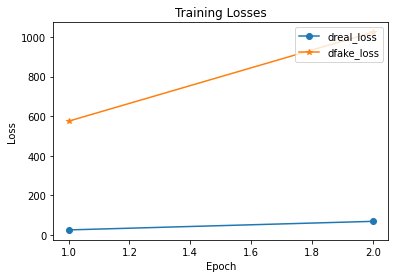

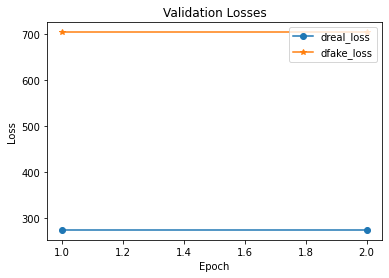

In [13]:

import yaml
from copy import deepcopy

from torch.utils.data import DataLoader

import torch

def get_dataLoaders(data_folder, dset, batch_size):
    # Initialize Dataloaders
    train_dataset = Dataset(data_folder, dset, split="train")
    val_dataset = Dataset(data_folder, dset, split="validation")
    test_dataset = Dataset(data_folder, dset, split="test")

    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=custom_collate_fn, drop_last=True)
    val_dataloader = DataLoader(val_dataset, batch_size=batch_size, collate_fn=custom_collate_fn, drop_last=True)
    test_dataloader = DataLoader(test_dataset, batch_size=batch_size, collate_fn=custom_collate_fn, drop_last=True)

    return train_dataloader, val_dataloader, test_dataloader


config_dict = {}

mode = "train"

# history_input_size: 804 # yelp = 804, rsc = 890, tb = 4042
config_dict["history_hidden_size"]= 512
config_dict["history_num_layers"]= 8

# generator_input_size: 9356  # yelp = 9356, rsc = 10302, tb = 44974
# generator_output_size: 11
config_dict["generator_n_hidden"]= 8
config_dict["generator_hidden_dim"]= 512 

# discriminator_input_size: 9356 # yelp = 9356, rsc = 10302, tb = 44974
# discriminator_output_size: 11
config_dict["discriminator_n_hidden"]= 8
config_dict["discriminator_hidden_dim"]= 512

config_dict["lr"]= 0.0006
config_dict["betas"]= [0.3,0.999]
config_dict["epochs"]= 2
config_dict["batch_size"]= 16
config_dict["k"]= [1, 2] # top k@precision's k values

config_dict["load_pretrained"]= False # load history_lstm, generator, and discrminator from checkpoints if given True
config_dict["ckpt_path"]= "checkpoints" # folder path to checkpoints
config_dict["pretrained_history_lstm_path"]= "best_lstm_ckpt.pth.tar" # history_lstm checkpoint to save/load model
config_dict["pretrained_discriminator_path"]= "best_discriminator_ckpt.pth.tar" # discriminator checkpoint to save/load model
config_dict["pretrained_generator_path"]= "best_generator_ckpt.pth.tar" # generator checkpoint to save/load model






#         == Parameters of the History_LSTM:
#             history_input_size (int): feature_dim of the actions.
#             history_hidden_size (int): dimension of the state representation vector (dim of output of the History_LSTM)
#             history_num_layers (int): number of recurrent layers in the History_LSTM.

#         == Parameters of the Generator_UserModel:
#             generator_input_size (int): equals ((num_displayed_items+1)*feature_dims + state_dim)
#             generator_output_size (int): equals (num_displayed_items+1)
#             generator_n_hidden (int): number of hidden layers in the generator model.
#             generator_hidden_dim (int): hidden dimension of the layers in the generator model.

#         == Parameters of teh Discriminator_RewardModel:
#             discriminator_input_size (int): should equal (num_displayed_items*feature_dims) + state_dim.
#             discriminator_output_size (int): should equal (num_displayed_items+1). 
#             discriminator_n_hidden (int): number of hidden layers of the Discriminator model's MLP.
#             discriminator_hidden_dim (int): hidden dimension of the layers of the Discriminator model's MLP.
        
#         == Hyperparameters of the training
#             lr (int): learning rate used by the optimizer.
#             betas (tuple): beta values used by the ADAM optimizer.
#             epochs (int): number of epochs to train. //






# Initialize dataloaders
data_folder = "./dropbox"
dset = "yelp" # choose rsc, tb, or yelp
assert dset in ["yelp", "rsc", "tb"]
train_dataloader, val_dataloader, test_dataloader = get_dataLoaders(data_folder, dset, config_dict['batch_size'])

if mode == "train":
  real_click_history, display_set, clicked_items = next(iter(train_dataloader))
  display_set_unpacked, _ = torch.nn.utils.rnn.pad_packed_sequence(display_set, batch_first=True)
elif mode == "test":
  real_click_history, display_set, clicked_items = next(iter(test_dataloader))
  display_set_unpacked, _ = torch.nn.utils.rnn.pad_packed_sequence(display_set, batch_first=True)
                        
config_dict["generator_output_size"] = display_set_unpacked.shape[-2] + 1
config_dict["discriminator_output_size"] = display_set_unpacked.shape[-2] + 1
config_dict["history_input_size"] = display_set_unpacked.shape[-1]
config_dict["generator_input_size"] = config_dict["history_hidden_size"] + (config_dict["generator_output_size"] * config_dict["history_input_size"])
config_dict["discriminator_input_size"] = config_dict["history_hidden_size"] + (config_dict["discriminator_output_size"] * config_dict["history_input_size"])

  # Initialize the GAN model
gan = GAN(config_dict, config_dict['history_input_size'], config_dict['history_hidden_size'], config_dict['history_num_layers'], \
        config_dict['generator_input_size'], config_dict['generator_output_size'], config_dict['generator_n_hidden'], config_dict['generator_hidden_dim'], \
            config_dict['discriminator_input_size'], config_dict['discriminator_output_size'], config_dict['discriminator_n_hidden'], config_dict['discriminator_hidden_dim'], \
                lr=config_dict['lr'], betas=config_dict['betas'], epochs=config_dict['epochs'])


    # Train/Test using the GAN model
if mode == "train":
  train_dreal_losses, train_dfake_losses, val_dreal_losses, val_dfake_losses = gan.gan_training_loop(train_dataloader, val_dataloader)
else:
  test_cur_dreal_loss, test_cur_dfake_loss = gan.test(test_dataloader)